# Section 4 - Computer vision-based machine learning #
## Mini-project 4: Introduction to `SciNet` architecture ##

## Dr. Antonin Vacheret (avachere@imperial.ac.uk) 
## High Energy Physics Group
## 523 Blackett Lab

#### The markdown comments were added by Shingo Hayashida (s.hayashida@imperial.ac.uk) ####
* [Original repository](https://github.com/fd17/SciNet_PyTorch)
* [Reference](https://arxiv.org/abs/1807.10300)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from models import SciNet
from utils import target_loss 
device = torch.device("cuda")

In [2]:
# Setup scinet model with 3 latent neurons
scinet = SciNet(50,1,3,64)

# Load and prepare training data
inputs = torch.Tensor(np.load("training_data/inputs.npy"))
outputs = torch.Tensor(np.load("training_data/outputs.npy"))
traindata = TensorDataset(inputs, outputs)
dataloader = DataLoader(traindata, batch_size=256,shuffle=True, num_workers=1)
     

The structure of `scinet` is a very simple network.

In [3]:
print(scinet)

SciNet(
  (enc1): Linear(in_features=50, out_features=64, bias=True)
  (enc2): Linear(in_features=64, out_features=64, bias=True)
  (latent): Linear(in_features=64, out_features=6, bias=True)
  (dec1): Linear(in_features=4, out_features=64, bias=True)
  (dec2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)


Training is stopped at epoch 20 to save time.

In [4]:
# Training setup
SAVE_PATH = "trained_models/scinet1.dat"
N_EPOCHS = 20 #100
optimizer = optim.Adam(scinet.parameters())
hist_error = []
hist_loss = []
beta = 0.5

# Training loop
for epoch in range(N_EPOCHS):  
    epoch_error = []
    epoch_loss = []
    for i_batch, minibatch in enumerate(dataloader):

        inputs, outputs = minibatch
        optimizer.zero_grad()
        pred = scinet.forward(inputs)
        
        loss = target_loss(pred, outputs) + beta * scinet.kl_loss
        loss.backward()
        optimizer.step()
        error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).detach().numpy()
        epoch_error.append(error)
        epoch_loss.append(loss.data.detach().numpy())
    hist_error.append(np.mean(epoch_error))
    hist_loss.append(np.mean(epoch_loss))
    print("Epoch %d -- loss %f, RMS error %f " % (epoch+1, hist_loss[-1], hist_error[-1]))
    
torch.save(scinet.state_dict(), SAVE_PATH)
print("Model saved to %s" % SAVE_PATH)

Epoch 1 -- loss 15.683833, RMS error 0.167526 
Epoch 2 -- loss 6.728651, RMS error 0.119888 
Epoch 3 -- loss 4.356395, RMS error 0.099458 
Epoch 4 -- loss 3.613062, RMS error 0.090862 
Epoch 5 -- loss 2.870888, RMS error 0.081965 
Epoch 6 -- loss 2.253100, RMS error 0.073955 
Epoch 7 -- loss 1.806874, RMS error 0.066875 
Epoch 8 -- loss 1.532069, RMS error 0.062435 
Epoch 9 -- loss 1.319365, RMS error 0.058359 
Epoch 10 -- loss 1.217200, RMS error 0.056388 
Epoch 11 -- loss 1.154410, RMS error 0.055126 
Epoch 12 -- loss 1.092834, RMS error 0.053788 
Epoch 13 -- loss 1.065153, RMS error 0.053271 
Epoch 14 -- loss 1.018676, RMS error 0.052144 
Epoch 15 -- loss 1.002565, RMS error 0.051854 
Epoch 16 -- loss 0.963863, RMS error 0.050796 
Epoch 17 -- loss 0.920495, RMS error 0.049742 
Epoch 18 -- loss 0.878666, RMS error 0.048542 
Epoch 19 -- loss 0.854573, RMS error 0.048195 
Epoch 20 -- loss 0.764745, RMS error 0.045803 
Model saved to trained_models/scinet1.dat


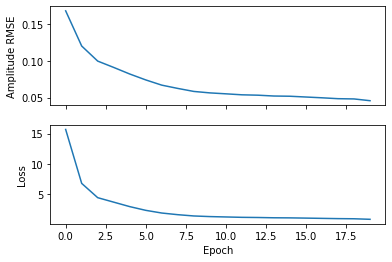

In [5]:
# Plot some training history data
%matplotlib inline 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(hist_error)
ax1.set_ylabel("Amplitude RMSE")
ax2.plot(hist_loss)
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
plt.show()